# Lab 3: Building A Search Agent

In this lab, we'll use the Azure AI Agent Service to create an agent that is able to retrieve information from documents stored in Azure AI Search, a vector database. The documents that we'll be searching are health insurance policies.

### Part 1: Create the Azure AI Search Index

We'll start the lab by creating an Azure AI Search index, which will contain vectorized representations of our health insurance plan documents.  We'll create the index directly in Azure AI Foundry. 

#### Step 1
To begin, download the [documents](https://github.com/Azure-Samples/azure-search-sample-data/tree/main/health-plan) that we'll store in the Azure AI Search index.

#### Step 2
Next, go to the Azure AI Foundry Portal. Navigate to **Data + indexes** under **My assets** in the side menu. Under **Upload, view data and indexes**, click on **Indexes**. Select the **New index** button.

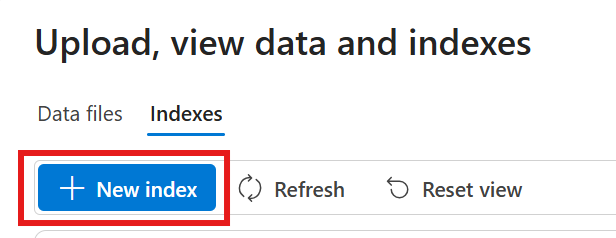
#### Step 3
Now we'll upload our health plan documents to our new index. For the **Data source** option, select **Upload files** and upload both of the health plan documents that you downloaded in Step 1. Select **Next**.

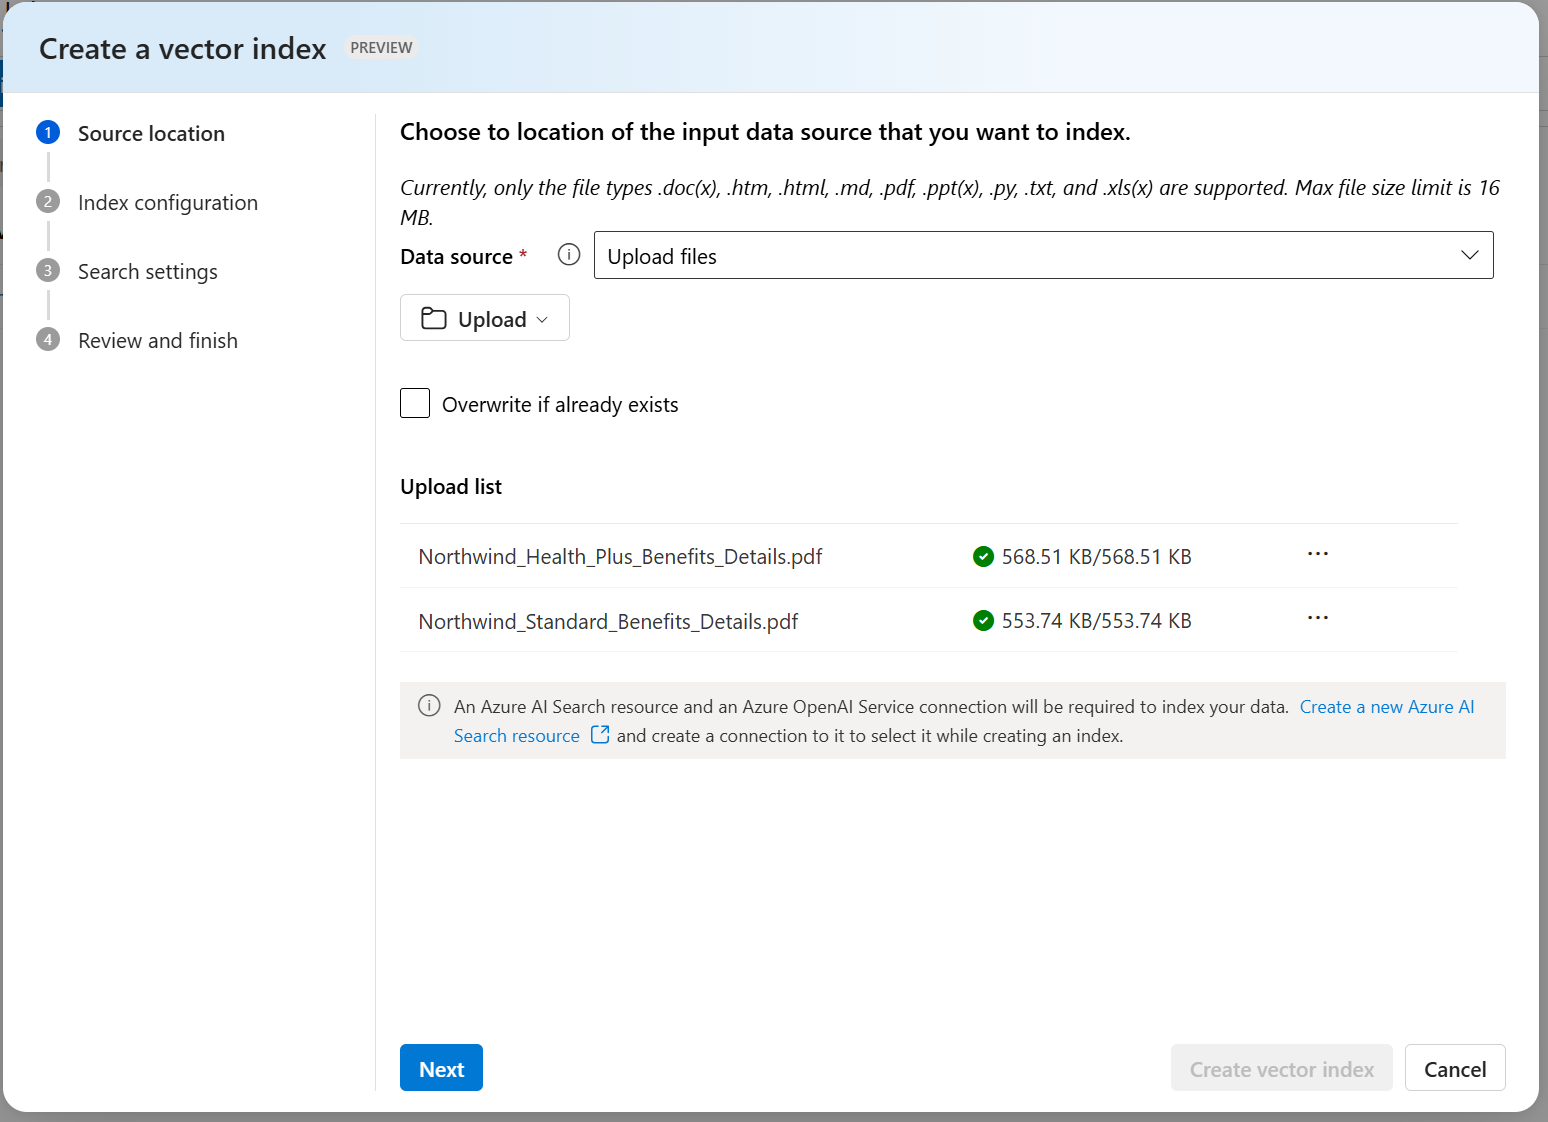

#### Step 4
Now we'll configure our index. Select your Azure AI Search Service from the drop-down and name your vector index **health-plan**. 

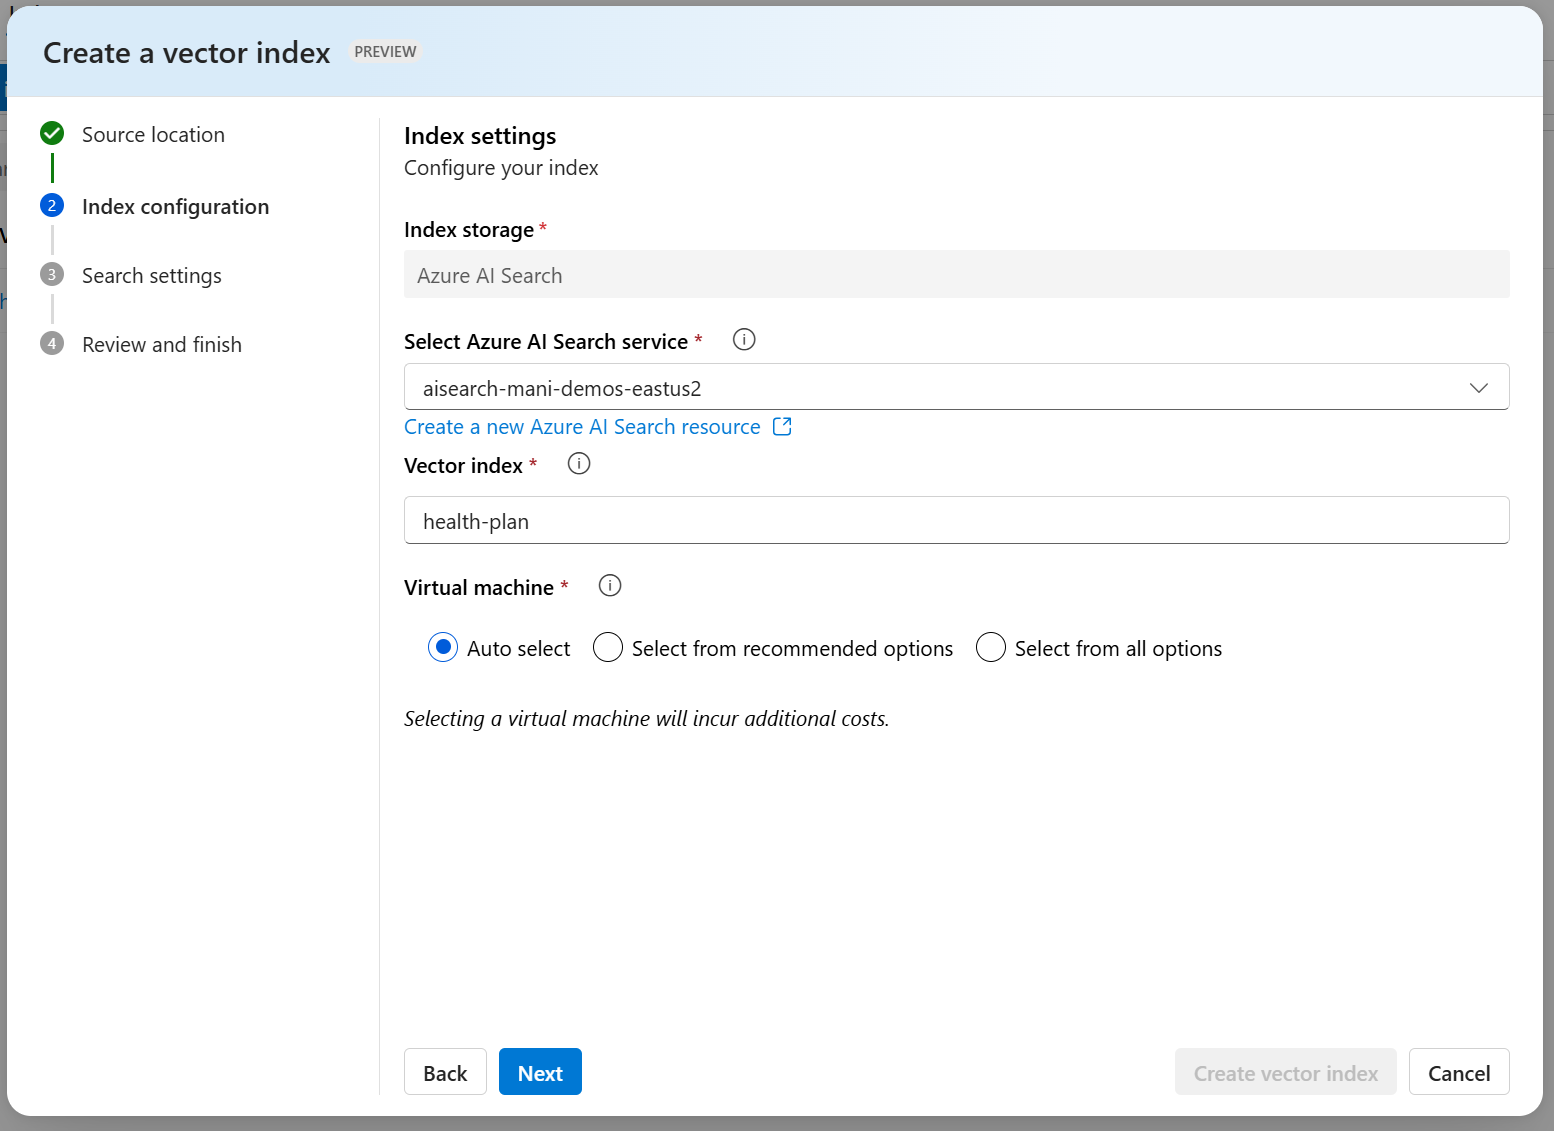

#### Step 5
Finally, we can configure vector search. The `text-embedding-3-large` embedding model will be used to create vector representations of the health plan documents. The Search Agent will then be able to search through these vectorized documents. Make sure **Add vector search to this search resource** is checked. Select the default **Azure OpenAI Service connection**.

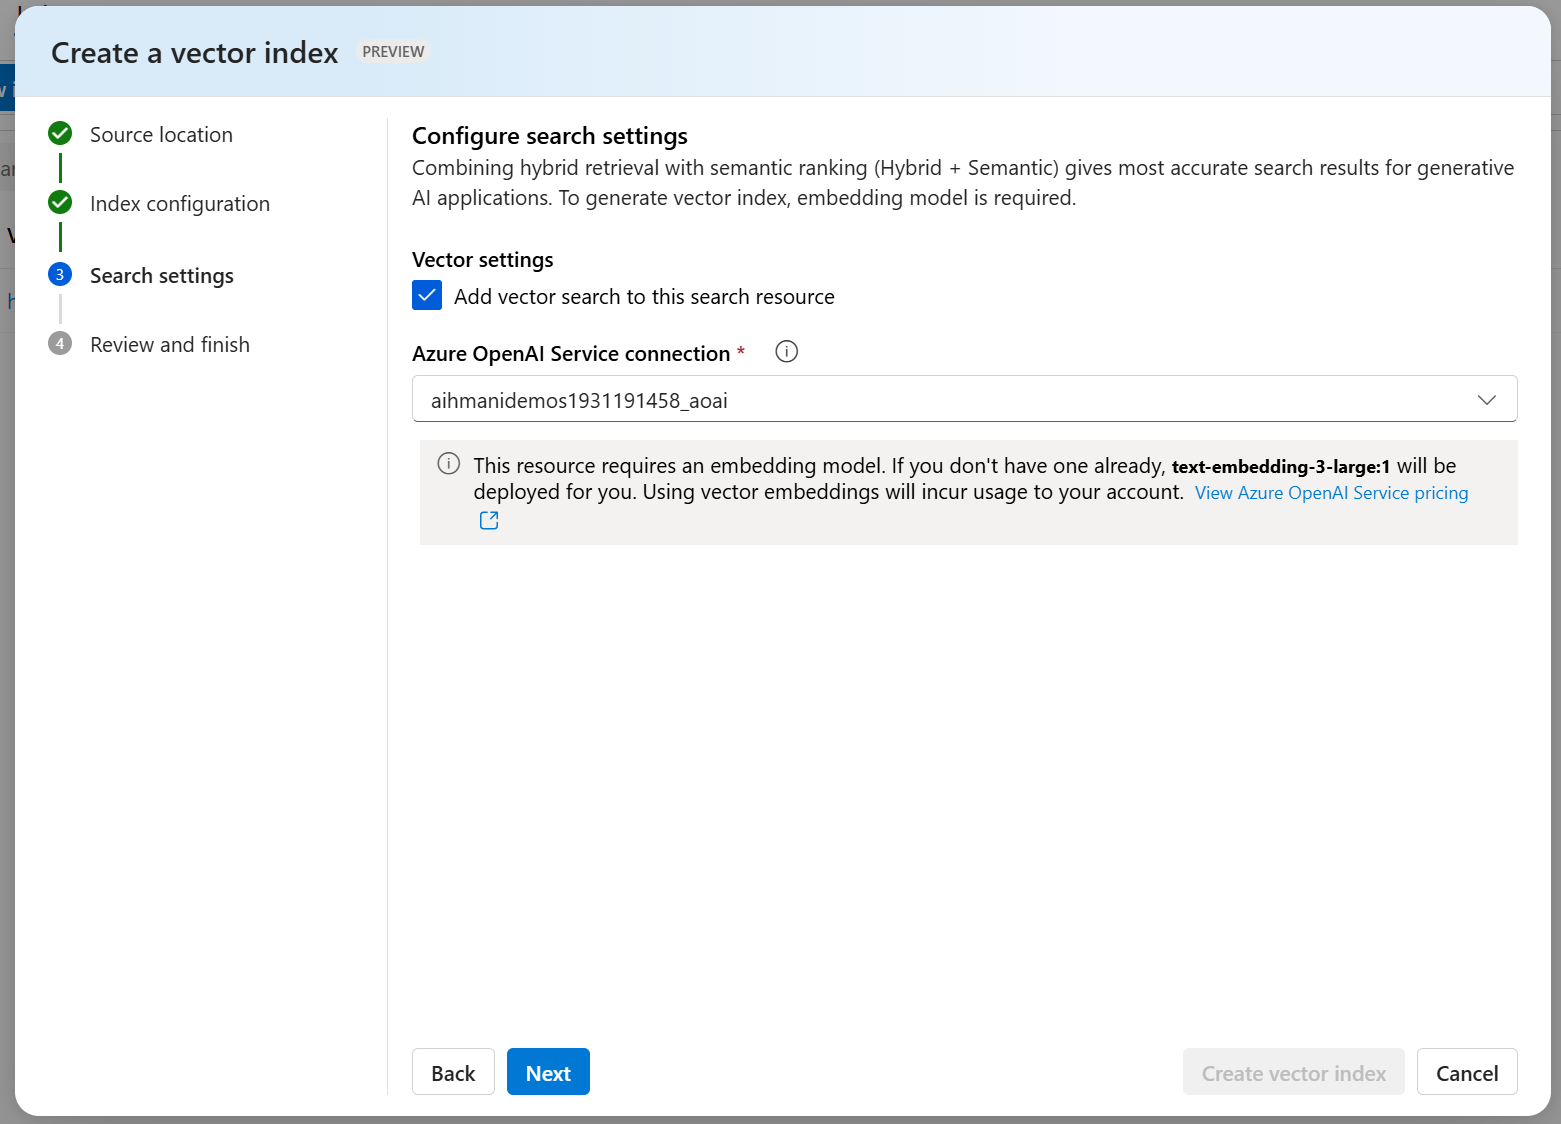



### Part 2: Create the Search Agent

Now that we've vectorized our health plan documents and created an index, we can create a Search Agent that will retreive information about our health plans from the index.


#### Step 1: Load the required libraries

In [ ]:
import os
from semantic_kernel.functions import kernel_function
from azure.ai.projects.models import ConnectionType
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.projects.models import AzureAISearchTool

load_dotenv() # Loads the environment variables and credentials we need to setup the agent

#### Step 2: Connect to your Azure AI Foundry project

In [2]:
# Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
    )

#### Step 3: Connect to your Azure AI Search index

In [3]:
# Get connection information for the Azure AI Search Service
search_connection = project_client.connections.get_default(
    connection_type=ConnectionType.AZURE_AI_SEARCH, include_credentials=True
)

# Connect to your Azure AI Search index
ai_search = AzureAISearchTool(index_connection_id=search_connection.id, index_name="health-plan")

#### Step 4: Define the search agent

In [4]:
search_agent = project_client.agents.create_agent(
    model="gpt-4o",
    name="search-agent",
    instructions="You are a helpful agent that is an expert at searching health plan documents.",
    tools=ai_search.definitions,
    tool_resources=ai_search.resources,
) 

#### Step 5: Chat with the search agent

Let's test our search agent by asking it to give us information about the Northwind Standard health plan.

In [ ]:
# The name of the health plan we want to search for
plan_name = 'Northwind Standard'

# Create a thread which is a conversation session between an agent and a user. 
thread = project_client.agents.create_thread()

# Create a message in the thread with the user asking for information about a specific health plan
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=f"Tell me about the {plan_name} plan.", # The user's message
)
# Run the agent to process tne message in the thread
run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=search_agent.id)

# Check if the run was successful
if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# Delete the agent when it's done running
project_client.agents.delete_agent(search_agent.id)

# Fetch all the messages from the thread
messages = project_client.agents.list_messages(thread_id=thread.id)

# Get the last message, which is the agent's resposne to the user's question
last_msg = messages.get_last_text_message_by_role("assistant")

# Display the agent's response
print('Agent:', last_msg.text.value)